# Práctica 2. Visión Estéreo

Visión Tridimensional 2020-21.<br>
Practica 2.
Abril 2021.

Este enunciado está en el archivo "PrácticaStereo2021_Alumnos.ipynb" o su versión "pdf" que puedes encontrar en el Aula Virtual.

## Objetivos


Los objetivos de esta práctica son:
* reconstruir puntos de una escena a partir de una serie de correspondencias manuales entre dos imágenes calibradas;
* determinar la geometría epipolar de un par de cámaras a partir de sus matrices de proyección;
* hacer una reconstrucción densa de la escena.

## Requerimientos

Para esta práctica es necesario disponer del siguiente software:
* Python 3.X 
* Jupyter http://jupyter.org/.
* Las librerías científicas de Python: NumPy, SciPy, y Matplotlib.
* La librería OpenCV

El material necesario para la práctica se puede descargar del Aula Virtual en la carpeta ``MaterialesPractica`` del tema de visión estéreo. Esta carpeta contiene:
* Una serie de pares estéreo en el directorio images;
el sufijo del fichero indica si corresponde a la cámara
izquierda (_left) o a la derecha (_right). Bajo el
directorio ``rectif`` se encuentran varios pares estéreo
rectificados.
* Un conjunto de funciones auxiliares de ``Python`` en 
el módulo ``misc.py``. La descripción de las funciones
puede consultarse con el comando help o leyendo
su código fuente.
* El archivo ``cameras.npz`` con las matrices de proyección del par de cámaras con el que se tomaron todas las imágenes con prefijo minoru.

## Condiciones

* La fecha límite de entrega será el viernes **10 de mayo de 2021 a las 23:55** (en el Aula Virtual)
* La entrega consiste en dos archivos con el código, resultados y respuestas a los ejercicios:
  1. Un "notebook" de Jupyter con los resultados. Las respuestas a los ejercicios debes introducirlas en tantas celdas de código o texto como creas necesarias, insertadas inmediatamente después de  un enuciado y antes del siguiente.
  2. Un documento "pdf" generado a partir del fuente de Jupyter, por ejemplo usando el comando ``jupyter nbconvert --execute --to pdf notebook.ipynb``, o simplemente imprimiendo el "notebook" desde el navegador en la opción del menú "File->Print preview". Asegúrate de que el documento "pdf" contiene todos los resultados correctamente ejecutados.

## 1. Introducción

En los problemas de visión estéreo se supondrá la existencia de un par de cámaras calibradas cuyas matrices de proyección $\mathbf{P}_i$ vienen dadas
por $$\mathbf{P}_1 = \mathbf{K}_1\cdot\begin{bmatrix}\mathbf{I} & \mathbf{0}\end{bmatrix}\cdot
    \begin{bmatrix}
        \mathbf{R}_1 & \mathbf{t}_1\\ \mathbf{0}^T & 1
    \end{bmatrix},$$ $$\mathbf{P}_2 = \mathbf{K}_2\cdot\begin{bmatrix}\mathbf{I} & \mathbf{0}\end{bmatrix}\cdot
    \begin{bmatrix}
        \mathbf{R}_2 & \mathbf{t}_2\\ \mathbf{0}^T & 1
    \end{bmatrix}.$$
    
En esta práctica se usarán las matrices de proyección de
dos cámaras para determinar la posición tridimensional
de puntos de una escena. Esto es posible siempre que se
conozcan las proyecciones de cada punto en ambas cámaras. Desafortunadamente, esta información no suele estar
disponible y para obtenerla es preciso emplear el contenido
de las imágenes (sus píxeles) en un proceso de búsqueda
conocido como puesta en correspondencia. Conocer las matrices de proyección de las cámaras permite acotar el área
de búsqueda gracias a las restricciones que proporciona la
geometría epipolar.

In [23]:
import numpy as np
import cv2
import numpy.linalg as npla
import misc
import matplotlib.pyplot as plt

from IPython.display import display, Latex, HTML

# %matplotlib notebook
%matplotlib tk

## 1. Reconstrucción

Teniendo un conjunto de correspondencias entre dos
imágenes, con matrices de calibración $P_i$ conocidas, es
posible llevar a cabo una reconstrucción tridimensional de
dichos puntos. En el fichero ``cameras.npz`` se encuentran
las matrices de proyección para las dos cámaras. Para cargar
este fichero:

In [2]:
cameras = np.load("cameras.npz")
P1 = cameras["left"]
P2 = cameras["right"]

print("P1=\n", P1)
print("P2=\n", P2)

P1=
 [[-1.59319023e+02  4.10068927e+02 -8.61429776e+01  5.96021124e+04]
 [ 9.56736123e+01 -6.85256589e+00 -4.31511155e+02  2.98592912e+04]
 [-8.69896273e-01 -7.51069223e-02 -4.87482742e-01  5.44164509e+02]]
P2=
 [[-1.49296958e+02  4.20482251e+02 -8.03699899e+01  2.66669558e+04]
 [ 9.61686671e+01 -2.92284678e+00 -4.41950717e+02  3.12991880e+04]
 [-8.64354364e-01 -5.83462724e-02 -4.99486983e-01  5.42414607e+02]]


Todas las imágenes con el prefijo minoru comparten este par de matrices de proyección.

Leemos las imágenes y marcamos al menos seis puntos correspondientes en cada una de ella.

In [3]:
img1 = cv2.imread("images/minoru_cube3_left.jpg")
img2 = cv2.imread("images/minoru_cube3_right.jpg")

In [4]:
# pt1, pt2 = misc.askpoints(img1,img2)

# Recomendación: Una vez marcados la primera vez con toda la precisión 
# posible, generar dos arrays de numpy aquí, pt1 y pt2, con las
# coordenadas marcadas (para no tener que volver a marcarlas). 
# Una vez colocadas esas variables ¡comentar el código que llama a 
# miscaskpoints!

pt1 = np.array([
    [105.9516129,  207.08064516, 305.10483871, 288.69354839, 202.64516129, 115.26612903],
    [ 23.36310484,  57.07278226,  25.13729839, 149.33084677, 204.33084677, 144.8953629 ],
    [  1.0       ,   1.0       ,   1.0       ,   1.0       ,   1.0       ,   1.0       ]])

pt2 = np.array([
    [  5.37903226,  83.0       , 205.86290323 ,200.98387097 , 96.75 ,       25.78225806],
    [ 27.35504032,  61.50826613,  28.2421371,  154.65342742, 210.09697581, 150.21794355],
    [  1.0       ,   1.0       ,   1.0       ,   1.0       ,   1.0       ,   1.0       ]])

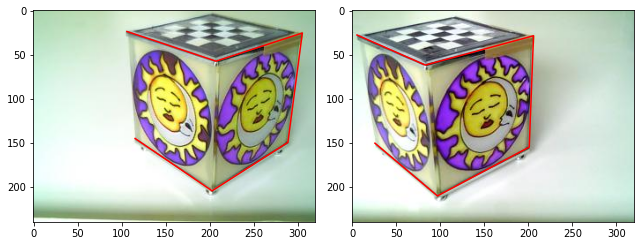

In [5]:
plt.figure(figsize=(9, 4))

ax1 = plt.subplot(1, 2, 1)
ax1.plot(pt1[0,:], pt1[1,:], '-r')
ax1.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))

ax2 = plt.subplot(1, 2, 2)
ax2.plot(pt2[0,:], pt2[1,:], '-r')
ax2.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))

plt.tight_layout(); plt.show()

**Ejercicio 1.** Implementa la función ``M = reconstruct(points1, points2, P1, P2)``
que, dados una serie de N puntos 2D ``points1`` de la primera imagen y sus 
N homólogos ``points2`` de la segunda imagen
(ambos en coordenadas homogéneas, 3 x N), y el par de matrices
de proyección P1 y P2 de la primera y la segunda cámara
respectivamente, calcule la reconstrucción tridimensional
de cada punto. De ese modo, si ``points1`` y
``points2`` son 3 × N , la matriz resultante M debe ser 4 × N.

El tipo de reconstrucción debe ser algebraico, no geométrico.


In [6]:
def reconstruct(points1, points2, P1, P2):
    """Reconstruct a set of points projected on two images."""
    
    M_homog = np.zeros((points1.shape[1], 4))
    
    # Transform homog to cartesian co-ordinates
    points1_cartesian = points1 / points1[2, :]
    points2_cartesian = points2 / points2[2, :]
    
    for i, (p1, p2) in enumerate(zip(points1_cartesian.T, 
                                     points2_cartesian.T)):
                
        # build coefficient matrix and compute reconstruction 
        # by least-squares.
        # Useful functions are npla.lstsq() and npla.pinv()
              
        system = [P1[0, ].T - p1[0] * P1[2, ].T, 
                  P1[1, ].T - p1[1] * P1[2, ].T,
                  P2[0, ].T - p2[0] * P2[2, ].T, 
                  P2[1, ].T - p2[1] * P2[2, ].T]

        system = np.array(system)

        A = system[:, :3]
        b = system[:, -1]

        M_cartesian = npla.pinv(A) @ -b
        M_homog[i] = [*M_cartesian, 1]
    
    return M_homog.T

Reconstruye los puntos marcados y pinta su estructura 3D.

C:\Users\europ\Desktop\MaterialesPrácticaEstéreo\misc.py:20: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


<Axes3D:xlabel='X', ylabel='Y'>

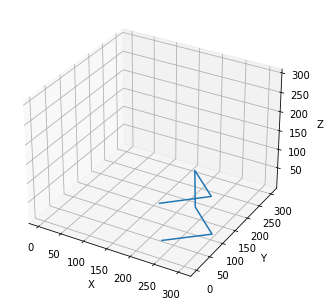

In [7]:
# reconstruct
mM = reconstruct(pt1, pt2, P1, P2)

# convert from homog to cartesian
mM /= mM[3, :]
mM /= mM[3, :]

# plot 3D
misc.plot3D(mM[0,:], mM[1,:], mM[2,:])

**Ejercicio 2.**  Elige un par estéreo de las imágenes del conjunto "building" de la práctica de calibración y realiza una reconstrucción de un conjunto de puntos de dicho edificio estableciendo las correspondencias a mano.

En este caso tenemos la cámara calibrada dado que las imágenes las hemos capturado con la misma cámara que en la práctrica de calibración. Nos faltarían la posición relativa entre una cámara y la otra. Utilizar algunas funciones de OpenCV en el módulo de calibración de calib3d puede ser de gran ayuda.

In [8]:
# De la práctica de calibración
K_building = np.array([[3.20010342e+03, 0.00000000e+00, 1.97743184e+03],
                       [0.00000000e+00, 3.20010342e+03, 1.45272425e+03],
                       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])
# No usar los parámetros de distorsión radial!!

img1_building = cv2.imread('building/build_001.jpg')
img2_building = cv2.imread('building/build_002.jpg')

# Get points in both images

pt1_building = np.array([
    [1.1380000e+03, 1.9795000e+03, 2.9805000e+03, 3.1510000e+03, 1.9905000e+03, 1.0225000e+03, 8.4650000e+02, 1.9795000e+03, 3.3435000e+03],
    [8.6740250e+02, 1.1940250e+02, 7.6840250e+02, 2.0114025e+03, 1.7639025e+03, 2.0719025e+03, 2.1764025e+03, 1.8409025e+03, 2.1159025e+03],
    [1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00]])

pt2_building = np.array([
    [9.4140000e+02, 1.7884000e+03, 2.7784000e+03, 2.9434000e+03, 1.8159000e+03, 8.2590000e+02, 6.4440000e+02, 1.7994000e+03, 3.1304000e+03],
    [8.2890250e+02, 1.0290250e+02, 7.7940250e+02, 1.9949025e+03, 1.7529025e+03, 2.0609025e+03, 2.1709025e+03, 1.8244025e+03, 2.0884025e+03],
    [1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00]])

# pt1_building, pt2_building = misc.askpoints(img1_building,img2_building)

In [9]:
pt1_building = np.array([[1.1380000e+03, 1.9740000e+03, 2.9695000e+03, 3.1510000e+03,
         1.9905000e+03, 1.0170000e+03, 8.4100000e+02, 1.9740000e+03,
         3.3380000e+03, 3.6790000e+03, 3.6350000e+03, 3.7615000e+03,
         3.5195000e+03, 3.3050000e+03, 3.2170000e+03, 2.8980000e+03,
         2.4195000e+03, 2.0070000e+03, 9.7850000e+02, 7.9700000e+02,
         1.9795000e+03],
        [8.6740250e+02, 1.2490250e+02, 7.6840250e+02, 2.0114025e+03,
         1.7639025e+03, 2.0774025e+03, 2.1819025e+03, 1.8409025e+03,
         2.1159025e+03, 2.0499025e+03, 2.1104025e+03, 2.6769025e+03,
         2.6879025e+03, 2.7594025e+03, 2.7044025e+03, 2.7209025e+03,
         2.7429025e+03, 2.7594025e+03, 2.7319025e+03, 2.5284025e+03,
         2.4239025e+03],
        [1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00,
         1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00,
         1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00,
         1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00,
         1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00,
         1.0000000e+00]])

pt2_building = np.array([[9.3590000e+02, 1.7884000e+03, 2.7784000e+03, 2.9489000e+03,
         1.8104000e+03, 8.2040000e+02, 6.4440000e+02, 1.7994000e+03,
         3.1359000e+03, 3.4494000e+03, 3.4054000e+03, 3.5319000e+03,
         3.3009000e+03, 3.0974000e+03, 3.0094000e+03, 2.7014000e+03,
         2.2449000e+03, 1.8269000e+03, 7.9290000e+02, 6.0040000e+02,
         1.8049000e+03],
        [8.3990250e+02, 9.7402500e+01, 7.7390250e+02, 1.9949025e+03,
         1.7529025e+03, 2.0609025e+03, 2.1654025e+03, 1.8299025e+03,
         2.0884025e+03, 2.0169025e+03, 2.0719025e+03, 2.6329025e+03,
         2.6384025e+03, 2.7099025e+03, 2.6659025e+03, 2.6824025e+03,
         2.7154025e+03, 2.7429025e+03, 2.7319025e+03, 2.5229025e+03,
         2.4019025e+03],
        [1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00,
         1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00,
         1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00,
         1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00,
         1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00,
         1.0000000e+00]])

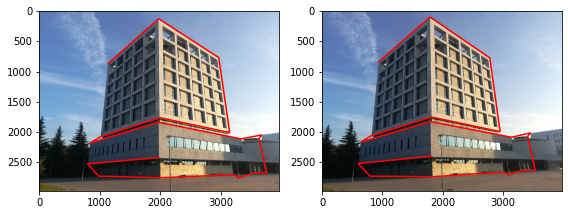

In [10]:
plt.figure(figsize=(8, 4))

ax1 = plt.subplot(1, 2, 1)
ax1.plot(pt1_building[0,:], pt1_building[1,:], '-r')
ax1.imshow(cv2.cvtColor(img1_building, cv2.COLOR_BGR2RGB))

ax2 = plt.subplot(1, 2, 2)
ax2.plot(pt2_building[0,:], pt2_building[1,:], '-r')
ax2.imshow(cv2.cvtColor(img2_building, cv2.COLOR_BGR2RGB))

plt.tight_layout(); plt.show()

C:\Users\europ\Desktop\MaterialesPrácticaEstéreo\misc.py:20: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


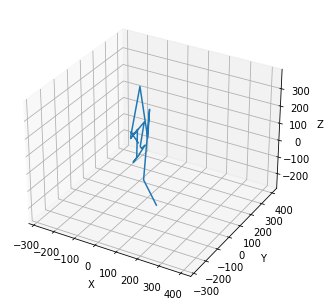

In [11]:
# Encontrar P1_building y P2_building 
# (matrices de proyección de las dos imágenes seleccionadas)

pt_left = pt1_building[:2, :].T
pt_right = pt2_building[:2, :].T

E = cv2.findEssentialMat(pt_left, pt_right, K_building)[0]
R, t = cv2.recoverPose(E, pt_left, pt_right, K_building)[1:3]

P1_building = K_building @ np.eye(3, 4) @ np.eye(4, 4)
P2_building = K_building @ np.eye(3, 4) @ np.vstack([np.hstack([R, t]), [0, 0, 0, 1]])

# reconstruct
mM_building = reconstruct( pt1_building, pt2_building, P1_building, P2_building )

# convert from homog to cartesian
mM_building /= mM_building[3, :]

# plot 3D
misc.plot3D(mM_building[0, :], mM_building[1, :], mM_building[2, :])
plt.show()

In [12]:
# El resto de la práctica lo podemos hacer con los datos de las 
# dos imágenes de prefijo minoru o las dos seleccionadas del directorio 
# building 

usar_par_estereo_building = False

if usar_par_estereo_building:
    P1 = P1_building
    P2 = P2_building
    img1 = img1_building
    img2 = img2_building
    pt1 = pt1_building
    pt2 = pt2_building
    K = K_building
    mM = mM_building

**Ejercicio 3.**  Reproyecta los resultados de la reconstrucción
en las dos cámaras y dibuja las proyecciones sobre las
imágenes originales. Pinta también en otro color los puntos seleccionados manualmente. Comprueba si las proyecciones coinciden con los puntos marcados a mano. Comenta los resultados.
Para dibujar los puntos puedes usar la función plothom
de la práctica anterior o la versión que se distribuye con esta
práctica (misc.plothom).

In [13]:
# Proyecto los puntos en ambas cámaras
proy1 = P1 @ mM
proy2 = P2 @ mM

proy1 /= proy1[2,:]
proy2 /= proy2[2,:]

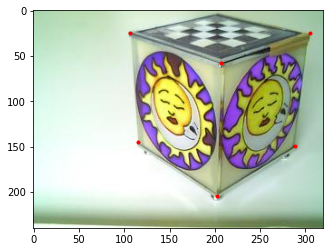

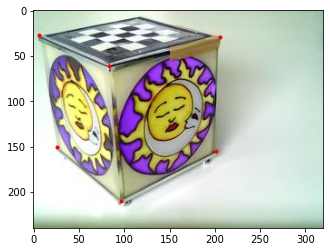

In [14]:
# Pinto con misc.plothom()
plt.figure()
misc.plothom(proy1,'r.')
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.show()

plt.figure()
misc.plothom(proy2,'r.')
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
plt.show()

## 2. Geometría epipolar

La geometría epipolar deriva de las relaciones que aparecen en las proyecciones de una escena sobre un par de
cámaras. La matriz fundamental $\mathbf{F}$, que depende exclusivamente de la configuración de las cámaras y no de la escena
que éstas observan, es la representación algebráica de dicha
geometría: a partir de ella se pueden calcular los epipolos
y las líneas epipolares. La relación entre un par de cámaras
$\mathbf{P}_1$, $\mathbf{P}_2$ y la matriz fundamental es de n -a- 1 (salvo factor de
escala). Es decir, dadas dos cámaras calibradas, sólo tienen
una matriz fundamental (excepto un factor de escala); dada
una matriz fundamental existen infinitas configuraciones de
cámaras posibles asociadas a ella.

### 2.1 Estimación de la matriz fundamental

**Ejercicio 4.** Implementa la función ``F = projmat2f(P1, P2)``
que, dadas dos matrices de proyección, calcule la matriz
fundamental asociada a las mismas. $\mathbf{F}$ debe ser tal que,
si $m_1$ de la imagen 1 y $m_2$ de la imagen 2 están en
correspondencia, entonces $m_2^\top F m_1 = 0$.

In [15]:
def decompose_projection_matrix(P1):
    K, R, C = cv2.decomposeProjectionMatrix(P1)[:3]
    C = (C[:-1] / C[-1])
    t = -R @ C
    return K, R, t, C

In [16]:
def projmat2f(P1, P2):
    """
    Calcula la matriz fundamental a partir de dos matrices de proyeccion
    """
    K1, R1, t1, _ = decompose_projection_matrix(P1)
    K2, R2, t2, _ = decompose_projection_matrix(P2)
    
    skewR2_R1 = misc.skew(R2.T @ t2 - R1.T @ t1)
    F = npla.pinv(K2).T @ R2 @ skewR2_R1 @ R1.T @ npla.pinv(K1)

    return F / F[2,2] if F[2,2] != 0 else F

In [17]:
# compute Fundamental matrix
F = projmat2f(P1, P2)
print("F =\n", F)

F =
 [[ 1.10036380e-06 -3.47150783e-04  1.13107937e-01]
 [ 1.07305234e-03  5.73532923e-04  1.80751930e+01]
 [-2.98810608e-01 -1.86707950e+01  1.00000000e+00]]


**Ejercicio 5** ¿Cómo es la matriz fundamental de dos cámaras
que comparten el mismo centro? (Por ejemplo, dos cámaras
que se diferencian sólo por una rotación.)

In [18]:
K1, R1, t1, _ = decompose_projection_matrix(P1)
K2, R2, t2, _ = decompose_projection_matrix(P2)

P1_ej_5 = K1 @ np.hstack([R1, t2])
P2_ej_5 = K2 @ np.hstack([R2, t2])

F_ej_5 = projmat2f(P1_ej_5, P2_ej_5)
print("F =\n", np.round(F_ej_5))

F =
 [[ 0. -0.  0.]
 [ 0. -0. -0.]
 [-0.  0.  1.]]


### 2.2 Comprobación de F

En los siguientes dos ejercicios vamos a comprobar que la matriz F estimada a partir de P1 y P2 es correcta.

**Ejercicio 6.** Comprueba que F es la matriz fundamental asociada a las cámaras ``P1`` y ``P2``. Para ello puedes utilizar el resultado 9.12, que aparece en la página 255 del libro Hartley, Zisserman. "Multipe View Geometry in Computer Vision." (sedond edition). Cambridge University Press, 2003:

"A non zero marix $F$ is a fundamental matrix corresponding to a pair of camera matrices $P$ and $P′$ if and only if $P'^TFP$ is skew symmetric" 

**Respuesta**

Una matriz $A$ es skew simétrica si y solo si $A^T = -A$.

In [19]:
A = P2.T @ (F @ P1)
np.allclose(np.round(A.T), np.round(-A))

True

También se puede comprobar geométricamente la bondad de una matriz F, si  las epipolares con ella estimadas pasan por el homólogo de un punto dado en una de las imágenes.

Dada la matriz fundamental $\mathbf{F}$ entre las cámaras 1 y 2,
se puede determinar, para un determinado punto $m_1$ en la
imagen de la cámara 1, cuál es la recta epipolar $l_2$ donde se
encontrará su homólogo en la cámara 2: $$l_2 = \mathbf{F} m_1.$$

Las siguientes dos funciones sirven para comprobar esta
propiedad. En primer lugar, se necesita una función que
dibuje rectas expresadas en coordenadas homogéneas, es
decir, la versión de plothom para rectas en lugar de puntos.

**Ejercicio 7.** Implementa la función ``plothline(line)``
que, dada una línea expresada en coordenadas homogéneas,
la dibuje.

In [ ]:
def plothline(line, axes = None):
    """Plot a line given its homogeneous coordinates.
    
    Parameters
    ----------
    line : array_like
        Homogeneous coordinates of the line.
    axes : AxesSubplot
        Axes where the line should be plotted. If not given,
        line will be plotted in the active axis.
    """    
    if axes == None:
        axes = plt.gca()
    
    [x0, x1, y0, y1] = axes.axis()
    
    #     (x0, y0) ._____________________. (x1, y0)
    #              |                     |
    #              |                     |
    #              |                     |
    #              |                     |
    #              |                     |
    #              |                     |
    #     (x0, y1) .---------------------. (x1, y1)
 
    
    # Compute the intersection of the line with the image
    # borders.
    
    p_i_t = np.cross(np.cross([x0, y0, 1], [x1, y0, 1]), line)
    p_i_t /= p_i_t[-1]
    
    p_i_r = np.cross(np.cross([x1, y0, 1], [x1, y1, 1]), line)
    p_i_r /= p_i_r[-1]
    
    p_i_b = np.cross(np.cross([x0, y1, 1], [x1, y1, 1]), line)
    p_i_b /= p_i_b[-1]

    p_i_l = np.cross(np.cross([x0, y0, 1], [x0, y1, 1]), line)
    p_i_l /= p_i_l[-1]
    
    # Plot the line with axes.plot
    p = np.array([p_i_l, p_i_t, p_i_b, p_i_r])
    plotline = axes.plot(p[:, 0], p[:, 1], 'r-')
    
    axes.axis([x0, x1, y0, y1])
    return plotline

**Ejercicio 8.** Completa la función ``plot_epipolar_lines(image1, image2, F)``
que, dadas dos imágenes y la matriz fundamental que
las relaciona, pide al usuario puntos en la imagen 1 y
dibuje sus correspondientes epipolares en la imagen 2 usando ``plothline``.

In [24]:
def plot_epipolar_lines(image1, image2, F):
    """
    Ask for points in one image and draw the epipolar lines for those points.
    
    Parameters
    ----------
    image1 : array_like
        First image.
    image2 : array_like
        Second image.
    F : array_like
        3x3 fundamental matrix from image1 to image2.
    """
    # Prepare the two images.
    fig = plt.gcf()
    fig.clf()
    
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)); ax1.axis('image')
    
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)); ax2.axis('image')
    plt.draw()
    
    ax1.set_xlabel("Choose points in left image (or right click to end)")
    point = plt.ginput(1, timeout=-1, show_clicks=False, mouse_pop=2, mouse_stop=3)
    
    while len(point) != 0:
        
        # point has the coordinates of the selected point in the first image.
        point = np.hstack([np.array(point[0]), 1])
        ax1.plot(point[0], point[1], '.r')
        
        # POR HACER: Determine the epipolar line.
        line = F @ point
        
        # Plot the epipolar line with plothline (the parameter 'axes' should be ax2).
        plothline(line, axes=ax2)
        
        plt.draw()
        # Ask for a new point.
        point = plt.ginput(1, timeout=-1, show_clicks=False, mouse_pop=2, mouse_stop=3)
    
    ax1.set_xlabel('')
    plt.draw()

Utiliza esta función con un par de imágenes llamándola
de dos formas diferentes: seleccionando puntos en la imagen
izquierda y dibujando las epipolares en la imagen derecha
y viceversa. Comprueba en ambos casos que las epipolares
siempre pasan por el punto de la segunda imagen correspondiente al seleccionado en la primera. Esto confirmara la corrección de la matriz F.

Añade dos figuras una que muestre la selección de puntos en
la imagen izquierda y las rectas correspondientes en la
imagen derecha, y otra que lo haga al revés. Indica para
ambos casos qué matriz fundamental has usado al llamar a
``plot_epipolar_lines``.

In [ ]:
# cambiar de %matplotlib notebook a %matplotlib tk en la celda de 
# 'imports' para ejecutar esta celda

plot_epipolar_lines(img1, img2, F)

$$l_2 = \mathbf{F} m_1$$
![Image](epipolar_lines_im1_im2_F.png)

In [73]:
# cambiar de %matplotlib notebook a %matplotlib tk en la celda de 
# 'imports' para ejecutar esta celda

# plot_epipolar_lines(img2, img1, F.T)

$$l_1 = \mathbf{F}^T m_2$$
![Image](epipolar_lines_im2_im1_F.T.png)

##  3. Rectificación de imágenes

La mayoría de algoritmos de puesta en correspondencia,
incluyendo el que se va a implementar en esta práctica,
requieren que las imágenes de entrada estén rectificadas.

Dos imágenes están rectificadas si sus correspondientes epipolares están alineadas horizontalmente. La rectificación de
imágenes facilita enormemente los algoritmos de puesta en
correspondencia, que pasan de ser problemas de búsqueda
bidimensional a problemas de búsqueda unidimensional
sobre filas de píxeles de las imágenes. En el material de
la práctica se han incluido dos funciones que rectifican
(mediante un método lineal) dos imágenes. La función
``H1, H2 = misc.projmat2rectify(P1, P2, imsize)``
devuelve, dadas las dos matrices de proyección y el tamaño de las imágenes en formato (filas,columnas), las
homografías que rectifican, respectivamente, la imagen 1
y la imagen 2. La función ``projmat2rectify`` hace uso
de ``projmat2f``, por lo que
es necesario que esta función esté disponible.

**Ejercicio 9.** Se tienen dos imágenes no rectificadas ``im1`` e
``im2``, y su matriz fundamental asociada $\mathbf{F}$ . Con el procedimiento explicado, se encuentran un par de homografías $\mathbf{H}_1$ y $\mathbf{H}_2$ que dan lugar a las imágenes rectificadas ``O1`` y ``O2``. ¿Cuál es la matriz fundamental $\mathbf{F}′$ asociada a estas dos imágenes? ¿Por qué?

Nota: F ′ depende exclusivamente de F , H1 y H2.

**Ejercicio 10.** Rectifica el par de imágenes estéreo ``img1`` e ``img2`` implementando el algoritmo de ``Fusiello, Trucco y Verri`` visto en clase.

Para este ejercicio puede ser útil la función ``cv2.decomposeProjectionMatrix``.

In [74]:
def get_Kn_Rn(K1, K2, R1, R2, C1, C2):
    
    r1n = (C2 - C1).squeeze()    
    r2n = np.cross(R2[2, :], r1n)
    r3n = np.cross(r1n, r2n)

    Rn = np.array([r1n / npla.norm(r1n), 
                   r2n / npla.norm(r2n), 
                   r3n / npla.norm(r3n)])
    
    Kn = (K1 + K2) / 2
    Kn[0, 1] = 0 # sesgo = 0
    
    return Kn, Rn


def projmat2rectify_fusiello(P1, P2):
    
    K1, R1, _, C1 = decompose_projection_matrix(P1)
    K2, R2, _, C2 = decompose_projection_matrix(P2)
    
    Kn, Rn = get_Kn_Rn(K1, K2, R1, R2, C1, C2)

    H1 = Kn @ Rn @ R1.T @ npla.inv(K1)
    H2 = Kn @ Rn @ R2.T @ npla.inv(K2)
    
    return H1, H2

In [75]:
H1, H2 = projmat2rectify_fusiello(P1, P2)
print("H1=\n", H1)
print("H2=\n", H2)
O1 = cv2.warpPerspective(img1, H1, (img1.shape[1], img1.shape[0]))
O2 = cv2.warpPerspective(img2, H2, (img2.shape[1], img2.shape[0]))

H1=
 [[ 1.01676012e+00 -3.86138637e-03 -1.51407995e+01]
 [ 1.59354261e-02  1.01298745e+00 -4.75367394e+00]
 [ 5.85838406e-05  3.12432335e-05  9.86843184e-01]]
H2=
 [[ 9.94383316e-01 -3.61872783e-03  4.41166520e-01]
 [ 6.11218289e-03  9.91177544e-01 -4.74904997e+00]
 [ 1.87336766e-05 -6.81749941e-08  9.97267063e-01]]


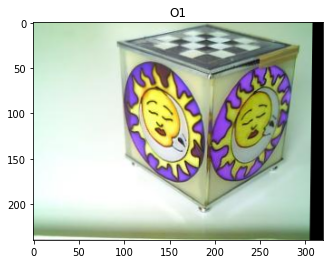

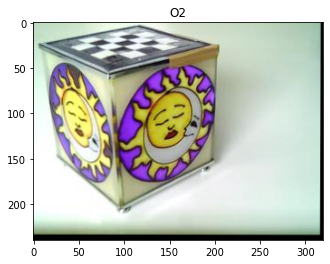

In [76]:
plt.figure()
plt.imshow(cv2.cvtColor(O1, cv2.COLOR_BGR2RGB))
plt.title("O1")
plt.figure()
plt.imshow(cv2.cvtColor(O2, cv2.COLOR_BGR2RGB))
plt.title("O2")
plt.show()

**Ejercicio 11.** Calcula y muestra la matriz fundamental de las imágenes
rectificadas. Justifica el resultado obtenido (mira la sección 9.3.1 del libro de Hartley y Zisserman, pág. 248 y 249).

Ya que estamos rectificando, hemos encontrado dos matrices de proyección $P$ y $P'$ donde los intrínsecos y los extrínsecos son los mismos, con la única diferencia de que una cámara está desplazada horizontalmente de la otra (distinta $t$). Tenemos entonces, $P = K[\,I\,|\,0\,]$ y $P'= K'[\,I\, |\, t\,]$. Si asumimos que $R = I$ y $K = K'$. 

$$F = [e']_{\times} KK^{-1} = [e']_{\times}$$

Si la translación es paralela al eje *x*, entonces $e'= (1, 0, 0)^{T}$ por lo que:

$$
F
=
\begin{bmatrix}
0 & 0 & 0\\ 
0 & 0 & -1\\ 
0 & 1 & 0
\end{bmatrix}
$$

In [77]:
K1, R1, _, C1 = decompose_projection_matrix(P1)
K2, R2, _, C2 = decompose_projection_matrix(P2)
    
Kn, Rn = get_Kn_Rn(K1, K2, R1, R2, C1, C2)

Pn1 = Kn @ np.hstack([Rn, -Rn @ C1])
Pn2 = Kn @ np.hstack([Rn, -Rn @ C2])

Fr = projmat2f(Pn1, Pn2)
Fr = Fr / Fr[2, 1]
print("Fr=\n", np.round(Fr))

Fr=
 [[ 0.  0.  0.]
 [-0. -0. -1.]
 [-0.  1.  0.]]


In [78]:
np.allclose(Fr.T, -Fr)

True

**Ejercicio 12.** Usa ``plot_epipolar_lines`` para dibujar varias líneas epiplares de las imágenes rectificadas. Muestra los resultados.

In [79]:
# cambiar de %matplotlib notebook a %matplotlib tk en la celda de 
# 'imports' para ejecutar esta celda

# plot_epipolar_lines(O1, O2, Fr)

![Image](epipolar_lines_o1_o2_Fr.png)

## 4. Búsqueda de correspondencias

La búsqueda de correspondencias consigue establecer automáticamente las correspondencias de puntos entre dos
imágenes (lo que se ha hecho manualmente en el ejercicio 2)
haciendo uso de las restricciones que proporciona la geometría epipolar.

### 4.1 Cálculo de las medidas de semejanza

Una vez rectificadas las dos imágenes de un par estéreo,
se pueden buscar las correspondencias. Una matriz de disparidades $\mathbf{S}$ indica, para cada píxel de la imagen 1
rectificada, a cuántos píxeles de diferencia está su correspondencia
en la imagen 2 rectificada. En la práctica, para simplificar el problema, podemos considerar que los elementos
de $\mathbf{S}$ son enteros. Para el píxel en la posición $(x, y)$ en la imagen 1, su correspondiente está en $(x + S[y, x], y)$ en la
imagen 2. Si $S[y, x] < 0$, la correspondencia está hacia la
izquierda; si $S[y, x] > 0$, la correspondencia está hacia la
derecha; si $S[y, x] = 0$, las coordenadas de los dos puntos
coinciden en ambas imágenes.

La búsqueda de correspondencias requiere ser capaz de
determinar el parecido visual entre píxeles de dos imágenes.
Si los píxeles $m_1$ y $m_2$ son visualmente parecidos, tienen
más probabilidad de estar en correspondencia que otros
que sean visualmente diferentes. Como la
apariencia (el nivel de gris) de un único píxel es propensa
al ruido y poco discriminativa, el elemento de puesta en
correspondencia será una ventana centrada en el píxel.
Dado un píxel $m$ de una imagen, llamaremos vecindad
del píxel de radio $K$ al conjunto de píxeles de la imagen que se encuentren dentro de una ventana de tamaño
$(2K + 1) × (2K + 1)$ píxeles centrada en $m$ . El número de
píxeles de una vecindad de radio $K$ es $N = (2K + 1)^2$.
Dadas dos vecindades $w_1$ y $w_2$ de dos píxeles, el parecido
visual entre ellas puede calcularse con la suma de *diferencias
al cuadrado (SSD)* de cada una de sus componentes
$$d_{SSD}(\mathbf{v}, \mathbf{w}) = \sum_{i=1}^N(\mathbf{v}_i - \mathbf{w}_i)^2.$$

La distancia $d_{SSD}$ es siempre positiva, es pequeña cuando
dos ventanas son visualmente parecidas y grande en caso
contrario.

### 4.2 Estimación de la disparidad sin regularizar

La implementación de cálculo de la disparidad para cada píxel pasa por obtener una matriz D con las distancias entre regiones a lo largo de la línea epipolar. El valor en D será un array de tamaño $M × N × L$, donde L es el número de disparidades a explorar,
``L = len(disps)``; M y N son, respectivamente, el
número de filas y de columnas de las imágenes de entrada.
El elemento ``D[y,x,l]`` debe ser la distancia entre la ventana centrada en ``im1[y,x]`` y la ventana centrada en ``im2[y,x + disps[l]]``.

``D[y,x,l]`` debe ser muy grande para aquellos valores en los que ``im2[y,x + disps[l]]`` no esté definido, es decir, el índice``(y,x+disps[l])`` se sale de la imagen 2.

La matriz D proporciona los costes unitarios $D_i$ de una función de energía sin regularización de la forma $$E(x) = \sum_{i} D_i(x_i),$$
donde $D_i(l)$ viene dado por $D[y,x,l]$, suponiendo que
el píxel $i$ tenga coordenadas $(x, y)$. Las variables 
$x = (x_1 ,\ldots, x_{NM})$ indican las etiquetas de cada uno de los
píxeles. En este caso, las etiquetas son los índices del
array ``disps``, que a su vez son las disparidades horizontales.
Por eso, a partir de aquí se hablará indistintamente de
etiquetas y disparidades. Sólo es necesario recordar que la
etiqueta $l$ está asociada a la disparidad ``disps[l]``.


Minimizando la energía $x = \arg\min_x E(x)$,
se obtiene un vector de etiquetas óptimo $x^*$ que indica, para
cada píxel, cuál es su disparidad horizontal entre las dos
imágenes.

### 4.3 Estimación de la disparidad regulariazada: StereoSGBM

Una vez rectificadas las dos imágenes de un par estéreo, 
y dadas las medidas de semejanza entre píxeles a lo largo 
de la línea epipolar para un rango de disparidades dado, se puede 
modificar la función de energía $E(x)$ para añadir términos de regularización. La idea es que píxeles cercanos tengan una disparidad parecida e intentar evitar los problemas de las zonas de la imagen sin textura.

En OpenCV tenemos implementado el algoritmo presentado en el siguiente artículo:

``Heiko Hirschmuller. Stereo processing by semiglobal matching and mutual information. IEEE Transactions on Pattern Analysis and Machine Intelligence, 30(2):328–341, 2008.``

Aunque la función de coste basada en Información Mútua del paper anterior se ha sustituido por la de Birchfield-Tomasi:

``Stan Birchfield and Carlo Tomasi. A pixel dissimilarity measure that is insensitive to image sampling. IEEE Transactions on Pattern Analysis and Machine Intelligence, 20(4):401–406, 1998.``


La clase que lo implementa el algoritmo de cálculo de disparidades es ``StereoSGBM``. Normalmente en un par estéreo se pretende reconstruir objetos que se encuentran más cerca, y a una distancia dada de la cámara. Esto nos dará lugar a una disparidad mínima a partir de la cual esos píxeles nos interesan (están más cerca que una distancia detertminada a la cámara). El parámetro ``minDisparity`` del algoritmo es crucial para lograr una estimación de disparidad adecuada. También es imporante el parámetro ``numDisparities`` para obtener una mayor o menor glanuralidad en las disparidades.

**Ejercicio 13.** Calcula las disparidades utilizando las imágenes rectificadas O1 y O2, mediante el algoritmo implementado en StereoSGBM.

In [80]:
# Para las imágenes del edificio de la URJC
if usar_par_estereo_building:
    
    stereo = cv2.StereoSGBM_create(
        minDisparity= 0,
        numDisparities = 5,
        blockSize = 3,
        P1 = 0,
        P2 = 0,
        disp12MaxDiff = 0,
        uniquenessRatio = 0,
        speckleWindowSize = 0,
        speckleRange = 0,
    )

    S = stereo.compute(O1, O2) # Disparidades para la imagen O1

In [82]:
# Para las imágenes del cubo 
if not usar_par_estereo_building:
    
    window_size = 11
    min_disp = 0
    num_disp = 112
    
    stereo = cv2.StereoSGBM_create(
        minDisparity=min_disp,
        numDisparities=num_disp,
        blockSize=window_size,
        P1= 8 * 1 * window_size ** 2,  # según la doc de opencv
        P2= 32 * 1 * window_size ** 2, # según la doc de opencv
        disp12MaxDiff=1,
        uniquenessRatio=6,
        speckleWindowSize=0,
        speckleRange=12
    )
    
    o1_gray = cv2.cvtColor(O1, cv2.COLOR_BGR2GRAY)
    o2_gray = cv2.cvtColor(O2, cv2.COLOR_BGR2GRAY)
    
    S = stereo.compute(o1_gray, o2_gray) # Disparidades para la imagen O1
    S = (S - np.min(S)) / (np.max(S) - np.min(S))
    S *= S.shape[1]

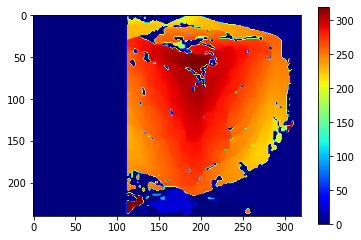

In [83]:
plt.figure()
plt.imshow(S,cmap='jet')
plt.colorbar()
plt.show()

**Ejercicio 14.** Implementa la función
``plot_correspondences(image1, image2, S, H1,H2)``
que, dado un par de imágenes sin rectificar, la matriz de
disparidades entre las imágenes rectificadas y las homografías que llevan de las imágenes sin rectificar a las imágenes
rectificadas, pida al usuario puntos en la primera imagen y
dibuje sus correspondencias en la segunda.

**Nota:** Hay que tener en cuenta que algunos puntos sobre zonas sin textura tendrán la disparidad incorrecta. Prueba a seleccionar puntos sobre esquinas y otros puntos muy fáciles de emparejar (en ellos la disparidad será aproximadamente correcta).

In [84]:
def plot_correspondences(image1, image2, S, H1, H2):
    """
    Ask for points in the first image and plot their correspondences in
    the second image.
    
    Parameters
    ----------
    image1, image2 : array_like
        The images (before rectification)
    S : array_like
        The matrix of disparities.
    H1, H2 : array_like
        The homographies which rectify both images.
    """
    # Prepare the two images.
    fig = plt.gcf()
    fig.clf()
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.imshow(image1)
    ax1.axis('image')
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.imshow(image2)
    ax2.axis('image')
    plt.draw()
    
    ax1.set_xlabel("Choose points in left image (or right click to end)")
    point = plt.ginput(1, timeout=-1, show_clicks=False, mouse_pop=2, mouse_stop=3)
    while len(point) != 0:
        # point has the coordinates of the selected point in the first image.
        point = np.c_[np.array(point), 1].T
        ax1.plot(point[0,:], point[1,:], '.r')
        
        # POR HACER: Determine the correspondence of 'point' in the second image.
        point_rectified = H1 @ point
        point_rectified /= point_rectified[-1]
        
        point_rectified_h2 = point_rectified
        point_rectified_h2[1] = point_rectified_h2[1, :] + S[int(point_rectified[0]), int(point_rectified[1])]
        
        point_on_img2 = npla.pinv(H2) @ point_rectified_h2
        point_on_img2 /= point_on_img2[-1]
        
        # POR HACER: Plot the correspondence with ax2.plot.

        ax2.plot(point_on_img2[0, :], point_on_img2[1, :] ,'r.')
        
        plt.draw()
        # Ask for a new point.
        point = plt.ginput(1, timeout=-1, show_clicks=False, mouse_pop=2, mouse_stop=3)
        
    ax1.set_xlabel('')
    plt.draw()

In [85]:
# plot_correspondences(img1, img2, S, H1, H2)

In [44]:
point = np.array([[250], [100], [1]])

In [63]:
point_rectified = H1 @ point
point_rectified /= point_rectified[-1]
print("\nPoint 1 rectified:\n", point_rectified)

point_rectified_h2 = point_rectified
point_rectified_h2[0] = point_rectified_h2[0] + S[int(point_rectified[1]), int(point_rectified[0])]
print("\nPoint 2 rectified:\n",point_rectified_h2)

point_on_img2 = npla.pinv(H2) @ point_rectified_h2
point_on_img2 /= point_on_img2[-1]
print("\nOn img2:\n", point_on_img2)


Point 1 rectified:
 [[237.56708452]
 [100.06727028]
 [  1.        ]]

Point 2 rectified:
 [[513.99565595]
 [100.06727028]
 [  1.        ]]

On img2:
 [[520.45447764]
 [103.24758105]
 [  1.        ]]


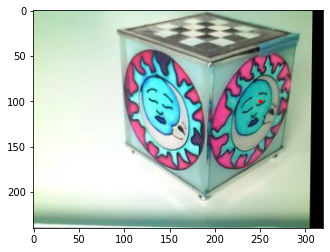

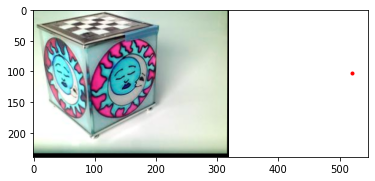

In [50]:
plt.imshow(O1)
plt.plot(point[0], point[1], '.r')
plt.show()
plt.imshow(O2)
plt.plot(point_on_img2[0], point_on_img2[1], '.r')
plt.show()